# Classification with Convolutional Neural Network Using PyTorch

ในบทเรียนนี้เราจะทดลองสร้าง Convolutional Neural Network ซึ่งเป็น Neural Network ที่ใช้ฟีเจอร์เชิงพื้นที่ (spatial features) ของภาพเพื่อนำมาช่วยใช้ในการเทรนและทำนายประเภทของภาพ โดยในตัวอย่างนี้เราจะใช้ภาพที่เราได้ทดลองใช้ตอนเรียนเรื่อง Principal Component Analysis (PCA) ซึ่งเป็นภาพที่ผู้ป่วยทดลองวาดนาฬิกา มาทดลองสร้างโมเดลเพื่อแบ่งประเภทกัน

ชุดข้อมูล: https://github.com/cccnlab/CDT-API-Network

โดยในขั้น ตอนของการสร้าง Convolutional Neural Network (CNN) นั้น ประกอบไปด้วย
1. เตรียม Dataset
2. กําหนด input layer โดยมีจํานวนมิติเท่ากับข้อมูลที่เตรียมมา
3. กําหนด convolutional layer และ pooling layer โดยอาจทําซํ้าได้หลายรอบสําหรับ
feature extraction และการลดขนาดมิติของข้อมูลในแต่ละ layer
4. กําหนด fully-connected (dense) layer
5. กําหนด logics layer หรือ out put layer ซึ่งในกรณีนี้คือการทํา classification ของ
ภาพนาฬิกาที่ถูกวาดโดยผู้ป่วยว่าปกติ (normal) หรือ ผิดปกติ (abnormal)

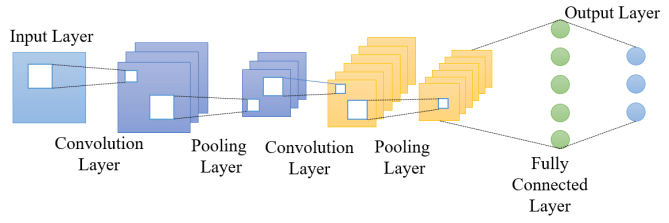
<br>
[ที่มา](https://www.researchgate.net/figure/Basic-architecture-of-CNN_fig3_335086346)

Convolution คือการดําเนินการทางคณิตศาสตร์ $f * g$ เพื่อแสดงให้เห็นผลของฟังก์ชัน $f$ ที่ เปลี่ยนแปลงไปเมื่อมีฟังก์ชัน $g$ โดยในรูปด้านล่าง สีม่วงคือ $f = [6,2,5,2,1,0,4,3,6,4]$ สีเขียว คือ $g = [6,5,4]$ และสีแดงคือ $f * g = [66,45,44,17,22,32,63,64]$

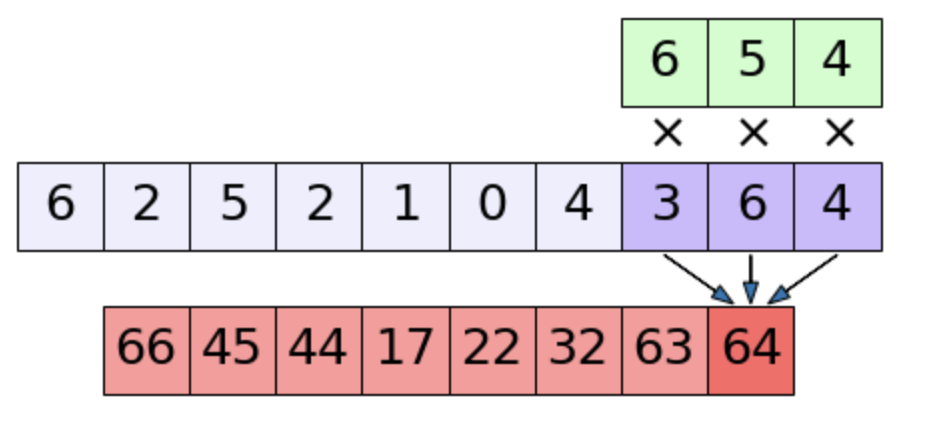

เพื่อเปรียบเทียบให้เห็นภาพชัด Convolution ถูกนํามาใช้ใน classic machine learning อย่างมาก สําหรับ การทํา feature extraction ในรูปแบบ 2D โดยมี $f$ คือ image และ $g$ คือ
filter (หรืออาจเรียกว่า kernel) โดยใน convolutional layer สามารถเลือกปรับ ขนาดของ input (padding) หรือ ขนาดการเลื่อนของการแสกน (stride) ได้ มีผลลัพธ์ท่ีได้จากการ คํานวณเรียกว่า Feature Map


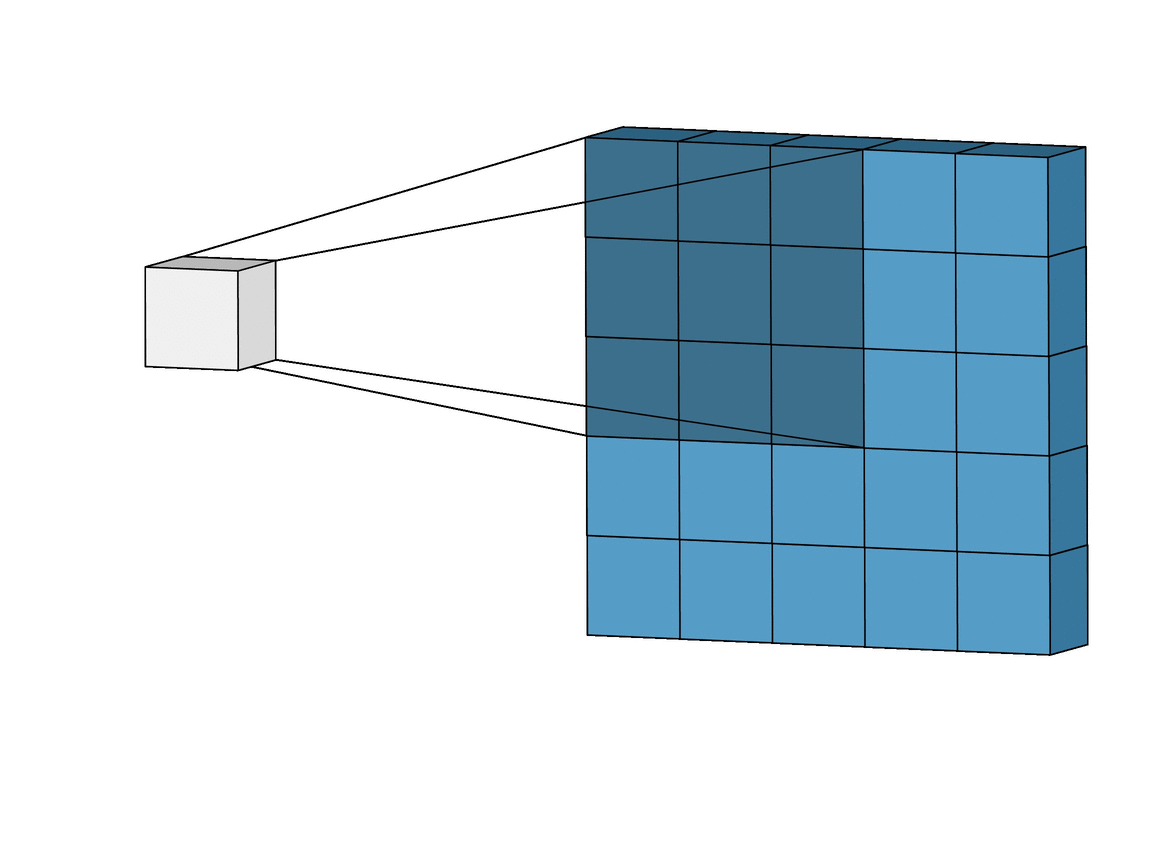

ในกรณี Back propagation จะมีกระบวนการเรียนรู้เพื่อปรับ filter (kernel) ของ convolutionallayerเพื่อให้มีผลลัพธ์ที่สูงที่สุด
โดย convolutional layer จะถูกส่งต่อไปยัง pooling layer เพื่อปรับขนาดภาพ และลดมิติของfeaturemapลง เพื่อให้โมเดลไม่จําเป็นต้องเรียนรู้ค่า weight ที่มีจํานวนมากเกินไป โดยมีเทคนิคที่นิยมคือ max pooling และ average pooling
โดย pooling layer สุดท้ายจะถูกรวม และเปลี่ยนรูปไปเป็น fully-connected layer เพื่อคํานวนเป็นoutputlayerใช้สําหรับ classification ภาพนาฬิกาที่ได้ยกนํามาเป็นตัว อย่างในบท นี้

## Download the Data

In [ ]:
# Download the dataset which contrains images and labels of the Clock Drawing Test (CDT)

!wget -O images.pickle https://github.com/ichatnun/brainCodeCamp2023/raw/main/Fundamentals/DimensionalityReduction/data/CDT/clock_images.pickle
!wget -O labels.pickle https://github.com/ichatnun/brainCodeCamp2023/raw/main/Fundamentals/DimensionalityReduction/data/CDT/labels.pickle

--2023-07-04 10:19:02--  https://github.com/ichatnun/brainCodeCamp/raw/main/Fundamentals/DimensionalityReduction/data/CDT/clock_images.pickle
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ichatnun/brainCodeCamp/main/Fundamentals/DimensionalityReduction/data/CDT/clock_images.pickle [following]
--2023-07-04 10:19:03--  https://raw.githubusercontent.com/ichatnun/brainCodeCamp/main/Fundamentals/DimensionalityReduction/data/CDT/clock_images.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1106083 (1.1M) [application/octet-stream]
Saving to: ‘images.pickle’

images.pickle       100%[==========

In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # module ที่เก็บ optimizer ต่างๆ ที่เราจะเอามาใช้ในการ train model
from torch.utils.data import Dataset, DataLoader # โหลด dataset มาใช้งาน
import torchvision # module สำหรับ computer vision ของ PyTorch
import torchvision.transforms as transforms # module สำหรับ transform รูปภาพ เช่น การปรับขนาดรูปภาพ การทำ data augmentation
from sklearn.model_selection import train_test_split # ใช้สำหรับแบ่งข้อมูลเป็น train/validation/test set
from glob import glob # ใช้สำหรับหา path ของไฟล์ในโฟลเดอร์
from PIL import Image # ใช้สำหรับโหลดรูปภาพ และแปลงรูปภาพให้เป็น array
from matplotlib import pyplot as plt # ใช้สำหรับ plot รูปภาพ
import pickle # ใช้สำหรับ save และ load ข้อมูล
import pandas as pd # ใช้สำหรับจัดการข้อมูลในรูปแบบของตาราง
import numpy as np # ใช้สำหรับจัดการข้อมูลในรูปแบบของ array
import os # ใช้สำหรับจัดการไฟล์และโฟลเดอร์

## Prepare Data

การเตรียมข้อมูลทำได้โดยการอ่านข้อมูลภาพจาก `images.pickle` และประเภทของภาพจาก `labels.pickle` เพื่อใช้ในการเตรียมข้อมูล จากนั้นเปลี่ยนเป็น dataframe

In [ ]:
# โหลดข้อมูลไฟล์ .pickle ที่เราได้ทำการ save ไว้ก่อนหน้านี้ และโหลดมาผ่าน wget จาก github
with open("images.pickle", "rb") as handle:
    images = pickle.load(handle)
with open("labels.pickle", "rb") as handle:
    labels = pickle.load(handle)

In [ ]:
# แปลงรูปภาพให้เป็น RGB array และเก็บไว้ใน list
list_images = []
for image in images:
    image = Image.fromarray(image) # Convert array to PIL image
    image = image.convert("RGB")  # Convert to RGB mode
    list_images.append(image)

สร้าง dataframe ที่เก็บข้อมูลที่จำเป็นต้องใช้ โดยมี column ดังนี้
- `Images` : ภาพที่ใช้ train
- `encoded_labels` : ค่า label โดย 0 คือ ปกติ และ 1 คือ ผิดปกติ

In [ ]:
df_data = pd.DataFrame(columns=["Images", "encoded_labels"]) # สร้าง dataframe เพื่อเก็บข้อมูลรูปภาพและ label ที่เป็นตัวเลข

# นำข้อมูลรูปภาพและ label มาเก็บไว้ใน dataframe
for img, label in zip(list_images, labels):
    df_data = df_data.append({"Images": img, "encoded_labels": label}, ignore_index=True)

<ipython-input-5-216431fcd8d8>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append({"Images": img, "encoded_labels": label}, ignore_index=True)
<ipython-input-5-216431fcd8d8>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append({"Images": img, "encoded_labels": label}, ignore_index=True)
<ipython-input-5-216431fcd8d8>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append({"Images": img, "encoded_labels": label}, ignore_index=True)
<ipython-input-5-216431fcd8d8>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_data = df_data.append({"Images": img, "encoded_labels": label},

## Split Data and Prepare DataLoaders

แบ่งข้อมูลเป็น train set (90%) และ test set (10%) โดยใช้ `train_test_split` จาก `sklearn.model_selection`

In [ ]:
# แบ่งข้อมูลเป็น train/validation/test set โดยใช้ train/validation set อยู่ในสัดส่วน 90:10
train_data, test_data = train_test_split(df_data, test_size=0.1, random_state=42)
len(train_data), len(test_data)

(54, 6)

สร้างชุดข้อมูล dataset จาก training และ testing โดยใช้ `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` โดย

- `Dataset` เป็น class ที่ใช้ในการกำหนดชุดข้อมูลของเรา โดยปกติจะประกอบด้วย 3 ฟังก์ชันหลักคือ `__init__` ใช้เพื่อประกาศค่าต่างๆ, `__len__` เป็นฟังก์ชันที่ให้ขนาดของชุดข้อมูล, และ `__getitem__` ที่มี index เป็น input และให้ `img` และ `label` ของ index นั้นๆออกมา
- `DataLoader` ส่วนมากจะใช้ร่วมกับ `Dataset` ที่เราสร้างขึ้น โดยเมื่อเราประกาศ `Dataset` แล้วจะสามารถนำ `DataLoader` มาครอบ `Dataset` เพื่อใช้ในการดึงข้อมูลออกมาเป็น batch ได้

In [ ]:
# สร้างขั้นตอนสำหรับการแปลงข้อมูลรูปภาพรวมเป็นตัวแปร transform โดย
# 1. ทำการแปลงรูปภาพให้เป็น tensor
# 2. ทำการ normalize รูปภาพด้วย mean และ standard deviation ของชุดข้อมูล
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

base_path = "CDT_dataset" # กำหนด path ของ dataset ที่เราจะเก็บไว้

# สร้าง class สำหรับการโหลด dataset ที่เราสร้างขึ้นมา
class CDT_dataset(Dataset): 
    def __init__(self, img_data, base_path, transform):
        self.img_data = img_data
        self.base_path = base_path
        self.transform = transform

    def __len__(self): # สร้าง function สำหรับ return จำนวนข้อมูลใน dataset ด้วยการใช้ len(...)
        return len(self.img_data)

    def __getitem__(self, index): # สร้าง function สำหรับ return ข้อมูลและ label ของข้อมูลใน dataset ด้วยการใช้ index
        # โหลดรูปภาพจาก path ที่เก็บไว้
        img = self.img_data.iloc[index]["Images"]
        # ลดขนาดภาพให้มีขนาด 32x32 เพื่อใช้ในการทำนาย
        img = img.resize((32, 32)) 
        # ถ้ามีการสร้างขั้นตอนการแปลงข้อมูลรูปภาพ ให้ทำการแปลงข้อมูลรูปภาพด้วย
        if self.transform is not None:
            img = self.transform(img)
        # สร้าง label ของข้อมูล
        label = self.img_data.iloc[index]["encoded_labels"]
        # ส่งข้อมูลรูปภาพและ label กลับไป
        return img, label


train_dataset = CDT_dataset(train_data, base_path, transform) # สร้าง train dataset
test_dataset = CDT_dataset(test_data, base_path, transform) # สร้าง test dataset

In [ ]:
# สร้าง train loader และ test loader โดยกำหนดให้มี batch size เท่ากับ 4 และ shuffle ข้อมูล
# โดยที่ DataLoader คือ class สำหรับการโหลดข้อมูลในรูปแบบของ batch
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True) # สร้าง train loader
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True) # สร้าง test loader

เขียนฟังก์ชันเพื่อยกตัวอย่างภาพที่ใช้ train โดยใช้ `next(iter(train_loader))` เพื่อดึงตัวอย่างออกมา 1 batch ในด้านบนเรากำหนดให้ `batch_size` มีค่าเท่ากับ 4

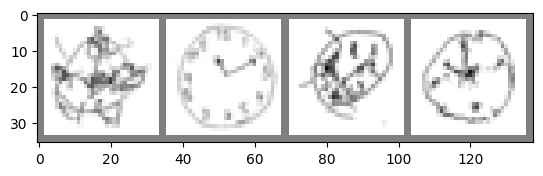

abnormal normal abnormal abnormal


In [ ]:
# สร้างฟังก์ชันสำหรับการแสดงรูปภาพและ label ของข้อมูลใน dataset
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images, labels = next(iter(train_loader)) # ดึงข้อมูลจาก train loader มาเก็บไว้ในตัวแปร images และ labels
# iter(...) คือ function สำหรับการสร้าง iterator ของ train loader
# next(...) คือ function สำหรับการดึงข้อมูลจาก iterator ของ train loader มาเก็บไว้ในตัวแปร images และ labels

SD_type = {0: "normal", 1: "abnormal"} # สร้าง dictionary สำหรับแปลง label ที่เป็นตัวเลขเป็นชื่อของ class

imshow(torchvision.utils.make_grid(images)) # แสดงรูปภาพที่อยู่ในตัวแปร images
classes = ("normal", "abnormal") # กำหนดชื่อของ class ที่เรามี
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(4))) # แสดง label ของข้อมูลที่อยู่ในตัวแปร labels

## Introduction to Convolution
convolution เป็นวิธีการนึ่งที่ที่ดูการเปลี่ยนแปลงของฟังก์ชั่นหนึ่ง เมื่อมีอีกฟังก์ชั่นเข้ามา ใน deep-learning convolution ถูกนำมาใช้อย่างแพร่หลายในงานที่เกี่ยวกับรูปภาพเพื่อดึงข้อมูลเชิงพื้นที่ (spatial feature) ออกมาจากรูปภาพ โดย pytorch จะใช้คำสั่ง `nn.Conv2d` ในการทำ convolution
โดย parameters ที่สำคัญจะประกอบไปด้วย
* `in_channels`: input image channel
* `out_channels`: output channel หลังจาก convolve แล้ว
* `kernel_size`: ขนาดของ filter ที่นำมา convolve กับรูปของเรา
* `stride`: filter จะเคลื่อนที่ทีละกี่ pixel ค่า default = 1
* `padding`: padding รูปภาพ ค่า default = 0

ภาพที่ได้หลังจากการ convolution อาจจะมีขนาด/depthเปลี่ยนไปขึ้นอยู่กับ parametersซึ่งเราสามารถคำนวนขนาดของภาพที่ออกมาได้ดังนี้

`output_size = ((input_size - kernel_size + 2 * padding) / stride) + 1`

In [ ]:
# สมมุติว่ามีรูปภาพ 1 ภาพ ขนาด 5x5 และมี 3 ช่องสี
input = torch.randn(1, 3, 5, 5)
input.shape

torch.Size([1, 3, 5, 5])

In [ ]:
conv = nn.Conv2d(in_channels=3, # จำนวนช่องสีของภาพ
                 out_channels=16, # จำนวนช่องสีของภาพที่เราต้องการให้เป็น output
                 kernel_size=3, # ขนาดของ filter
                 stride=1, # ขนาดของการเคลื่อนที่ของ filter
                 padding=0) # จำนวนช่องสีที่เราต้องการให้เพิ่มเติมเพื่อให้ขนาดของภาพเท่าเดิม
# output size = (5 - 3 + 2*0)/1 + 1 = 3
output = conv(input) # ทำการคำนวนด้วยการป้อน input ลงไปใน conv ซึ่งเป็น object ที่เราสร้างไว้ให้ทำหน้าที่เป็น convolution ในสองมิติ 
output.shape # depth ของภาพจะเพิ่มเป็น 16และ dimension ของภาพจะเท่ากับการคำนวนคือ 3

torch.Size([1, 16, 3, 3])

## Train the Model

สร้าง model โดยใช้ `torch.nn.Module` ซึ่งเป็นตัวแบบของ Neural Network model ใน pytorch โดยมี layer ดังนี้
- Convolutional layer (`nn.Conv2d`) ซึ่งจะรับค่าทั้งหมด 3 ค่าคือ input depth, output depth และ kernel size ยกตัวอย่างเช่นในเลเยอร์แรก `nn.Conv2d(3, 6, 5)` จะรับ input depth ของภาพเท่ากับ 3 นั่นก็คือ RGB channel นั่นเอง และ output ออกมาเป็นภาพที่มี depth เท่ากับ 6
- จากนั้นก็จะส่งต่อไปให้ `nn.MaxPool2d(2, 2)` ซึ่งมี kernel size เท่ากับ 2 และ stride เท่ากับ 2 โดยจะลดขนาดของภาพเป็นครึ่งหนึ่งนั่นเอง (แต่ depth เท่าเดิม)

In [ ]:
class Net(nn.Module): # สร้าง class สำหรับการสร้างโมเดลจาก nn.Module
    def __init__(self): # สร้าง constructor ของ class
        super().__init__() # เรียกใช้ constructor ของ nn.Module
        self.conv1 = nn.Conv2d(3, 6, 5) # สร้าง convolution layer แรก โดยมี in_channels เท่ากับ 3 และ out_channels เท่ากับ 6 และมี kernel_size เท่ากับ 5
        self.pool = nn.MaxPool2d(2, 2) # สร้าง pooling layer โดยมี kernel_size เท่ากับ 2 และ stride เท่ากับ 2
        self.conv2 = nn.Conv2d(6, 16, 5) # สร้าง convolution layer ที่สอง โดยมี in_channels เท่ากับ 6 และ out_channels เท่ากับ 16 และมี kernel_size เท่ากับ 5
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # สร้าง fully connected layer แรก โดยมี in_features เท่ากับ 16 * 5 * 5 และ out_features เท่ากับ 120
        self.fc2 = nn.Linear(120, 84) # สร้าง fully connected layer ที่สอง โดยมี in_features เท่ากับ 120 และ out_features เท่ากับ 84
        self.fc3 = nn.Linear(84, 10) # สร้าง fully connected layer ที่สาม โดยมี in_features เท่ากับ 84 และ out_features เท่ากับ 10

    def forward(self, x): # สร้าง method สำหรับการทำ forward propagation
        x = self.pool(F.relu(self.conv1(x))) # ทำการ convolution และ pooling และ activation function (ReLu) ใน convolution layer แรก
        x = self.pool(F.relu(self.conv2(x))) # ทำการ convolution และ pooling และ activation function (ReLu) ใน convolution layer ที่สอง
        x = torch.flatten(x, 1)  # ทำการ flatten ข้อมูลใน x ให้เหลือแค่ batch dimension
        x = F.relu(self.fc1(x)) # ทำการแปลงผ่าน fully connected และ activation function (ReLu) ใน fully connected layer แรก
        x = F.relu(self.fc2(x)) # ทำการแปลงผ่าน fully connected และ activation function (ReLu) ใน fully connected layer ที่สอง
        x = self.fc3(x) # ทำการแปลงผ่าน fully connected ใน fully connected layer สุดท้าย
        return x # ส่งค่า x กลับ


model = Net() # สร้าง object ของ class Net

**เราทราบได้อย่างไรว่า class ที่เราสร้างขึ้น มี network layer เชื่อมต่อกันอย่างไร**
<details>
    <summary>
        เฉลย
    </summary>
    เราสามารถดูได้จากขั้นตอนการแปลง input ผ่าน method `forward` ที่อยู่ใน class ได้ โดยจากตัวอย่างด้านบน จะพบว่า network ของเรามีการเชื่อมต่อกันแบบเรียงลำดับดังนี้
    <ol>
    <li>conv1 + ReLu</li>
    <li>conv2 + ReLu</li>
    <li>fc1 + ReLu</li>
    <li>fc2 + ReLu</li>
    <li>fc3</li>
    </ol>
    โดยที่ activation function นั้นจะมีหรือไม่มีหลังจากที่ทำการคำนวณใน layer แต่ละอันก็ได้
</details>

กำหนด `hyperparameters` ที่จำเป็นต้องใช้ ได้แก่ loss function ซึ่งคือ `CrossEntropyLoss`, optimizer ซึ่งคือ `Adam` ที่รับพารามิเตอร์ของโมเดล จากนั้นเทรนโมเดลโดยใส่ชุดข้อมูลเข้าไปในโมเดล และทำการอัพเดทโมเดลด้วยการคำนวณ  gradient (`loss.backward()`) และอัพเดทพารามิเตอร์ของโมเดล (`optimizer.step()`)

In [ ]:
# Define a Loss function and optimizer

criterion = nn.CrossEntropyLoss() # กำหนด loss function ที่ใช้ในการคำนวนค่า loss เป็นค่า Cross Entropy Loss ซึ่งหมายถึง การคำนวนค่า loss โดยใช้ค่าความแตกต่างของค่าความน่าจะเป็นของคลาสที่เราต้องการกับค่าความน่าจะเป็นของคลาสอื่นๆ
optimizer = optim.Adam(model.parameters(), lr=0.001) # กำหนด optimizer ที่ใช้ในการปรับค่า parameter ของโมเดลให้เป็น optimizer แบบ Adam ซึ่งเป็น optimizer ที่ใช้ในการปรับค่า parameter โดยใช้การคำนวนค่า gradient ของ parameter แต่ละตัวเพื่อใช้ในการปรับค่า parameter โดยใช้ learning rate เท่ากับ 0.001

In [ ]:
for epoch in range(100): # ทำการ train model โดยใช้จำนวน epoch เท่ากับ 100
    running_loss = 0.0 # กำหนดค่าเริ่มต้นของ running loss เท่ากับ 0
    for i, data in enumerate(train_loader, 0): # ทำการวน loop ในแต่ละ batch ของ train_loader
        inputs, labels = data # ดึงข้อมูลและ label จาก data
        optimizer.zero_grad() # ทำการปรับค่า gradient เป็น 0 ก่อนการคำนวนค่า gradient ของ parameter แต่ละตัว เนื่องจากการคำนวณ gradient ด้วย backpropagation จะเก็บค่า gradient ไว้ในตัวแปรเดียวกันเรื่อยๆ จนกว่าจะมีการเรียกใช้ method zero_grad() เพื่อทำการเคลียร์ค่า gradient ในตัวแปรนั้น
        outputs = model(inputs) # ทำการ forward propagation โดยใช้ข้อมูลใน inputs ที่ได้จาก data ที่วน loop อยู่
        loss = criterion(outputs, labels) # ทำการคำนวณค่า loss โดยใช้ค่า output ที่ได้จากการทำ forward propagation กับ label ที่ได้จาก data ที่วน loop อยู่
        loss.backward() # ทำการคำนวณค่า gradient ของ parameter แต่ละตัวโดยใช้ backpropagation
        optimizer.step() # ทำการปรับค่า parameter ของโมเดลด้วยค่า gradient ที่คำนวณได้
        running_loss += loss.item() # ทำการบวกค่า loss ในแต่ละ batch เข้ากับ running loss เพื่อใช้ในการคำนวณค่า loss ในแต่ละ epoch
        if i % 10 == 9: # ทำการ print ค่า loss ในแต่ละ batch ทุกๆ 10 batch
            print(f"[epoch: {epoch + 1} ] loss: {running_loss / 1:.3f}")
            running_loss = 0.0 # ทำการเคลียร์ค่า running loss เพื่อใช้ในการคำนวณค่า loss ใน batch ถัดไป

print("Finished Training")

[epoch: 1 ] loss: 20.075
[epoch: 2 ] loss: 8.571
[epoch: 3 ] loss: 9.308
[epoch: 4 ] loss: 7.529
[epoch: 5 ] loss: 6.981
[epoch: 6 ] loss: 7.147
[epoch: 7 ] loss: 6.895
[epoch: 8 ] loss: 7.352
[epoch: 9 ] loss: 6.986
[epoch: 10 ] loss: 7.029
[epoch: 11 ] loss: 7.027
[epoch: 12 ] loss: 7.004
[epoch: 13 ] loss: 7.241
[epoch: 14 ] loss: 7.126
[epoch: 15 ] loss: 6.847
[epoch: 16 ] loss: 6.681
[epoch: 17 ] loss: 6.850
[epoch: 18 ] loss: 6.481
[epoch: 19 ] loss: 6.609
[epoch: 20 ] loss: 5.753
[epoch: 21 ] loss: 5.363
[epoch: 22 ] loss: 3.350
[epoch: 23 ] loss: 3.134
[epoch: 24 ] loss: 1.701
[epoch: 25 ] loss: 2.908
[epoch: 26 ] loss: 1.856
[epoch: 27 ] loss: 1.559
[epoch: 28 ] loss: 0.711
[epoch: 29 ] loss: 0.615
[epoch: 30 ] loss: 0.605
[epoch: 31 ] loss: 1.207
[epoch: 32 ] loss: 0.896
[epoch: 33 ] loss: 0.525
[epoch: 34 ] loss: 0.756
[epoch: 35 ] loss: 0.229
[epoch: 36 ] loss: 0.151
[epoch: 37 ] loss: 0.324
[epoch: 38 ] loss: 0.378
[epoch: 39 ] loss: 0.846
[epoch: 40 ] loss: 0.418
[epoch: 

In [ ]:
# Save the model
PATH = "./CDT_model.pth"
torch.save(model.state_dict(), PATH) # ทำการบันทึกโมเดลที่ได้จากการ train เป็นไฟล์ .pth โดย .state_dict() จะเป็นการบันทึกเฉพาะค่า parameter ของโมเดลเท่านั้น

### Test the Data

ทดลองนำภาพตัวอย่างจาก test set มาทำนายด้วยโมเดลที่เราได้เทรนไป

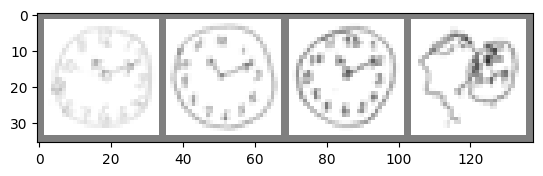

GroundTruth:  normal normal normal abnormal


In [ ]:
dataiter = iter(test_loader) # ทำการสร้าง object ของ test_loader ให้เป็น iterator
images, labels = next(dataiter) # ทำการดึงข้อมูลและ label จาก test_loader ที่เป็น iterator ออกมา

# print images
imshow(torchvision.utils.make_grid(images)) # ทำการแสดงรูปภาพที่อยู่ใน images ที่เป็น tensor ในรูปแบบของ grid
print("GroundTruth: ", " ".join(f"{classes[labels[j]]:5s}" for j in range(4))) # ทำการแสดง label ของรูปภาพที่อยู่ใน images ที่เป็น tensor ในรูปแบบของ grid

ในการใช้งานจริงเราสามารถสร้างโมเดล และอ่าน weights (หรือ parameters) ของโมเดลที่เทรนไว้แล้ว เพื่อนำมาใช้ทำนายเลยได้ ไม่จำเป็นต้องเทรนใหม่

In [ ]:
model = Net() # สร้าง object ของ class Net ที่เป็นโมเดลที่เราสร้างไว้
model.load_state_dict(torch.load(PATH)) # ทำการโหลดค่า parameter ของโมเดลจากไฟล์ .pth ที่เราบันทึกไว้ก่อนหน้านี้

<All keys matched successfully>

In [ ]:
# Predictions
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join(f"{classes[predicted[j]]:5s}" for j in range(4)))

Predicted:  normal normal normal abnormal


ในตัวอย่างนี้เราเพียงแค่ต้องการโชว์กระบวนการเบื้องต้นของการสร้างและเทรนโมเดล Convolutional Neural Network เท่านั่นแต่ในเทรนโมเดลจริงนั่นเรายังต้องคำนึงถึงปัจจัยอื่นๆอีกมากมาย เช่น การ overfit ของโมเดล, การปรับหน้าตาของโมเดล, การใช้ optimizer แบบอื่นๆ ที่เป็นปัจจัยในการเทรนโมเดลให้มีประสิทธิภาพ

นอกจากนี้ปัจจุบัน CNN ได้ถูกออกแบบและพัฒนาให้มีรูปแบบที่ซับซ้อนขึ้นเพื่อให้ได้ความแม่นยำที่มากขึ้นเช่น VGG, DenseNet, ResNet รวมถึงจะมีการเทรนโมเดลเหล่านั้นกับข้อมูลขนาดใหญ่แล้วค่อยนำมา fine-tune เพื่อให้เหมาะสมกับ task ที่เราต้องการทำให้ลดเวลาในการเทรนและเพิ่มความแม่นยำให้กับโมเดลได้ โดยในบทถัดๆไปจะเป็นการยกตัวอย่างการ download โมเดลที่ซับซ้อนขึ้นที่ถูกเทรนมาแล้ว และนำมาใช้ในงานของเรา เช่น
* Classification
* Object detection
* Semantic Segmentation

<br><br>
**ผู้จัดเตรียม code ใน tutorial**: ดร. ฐิติพัทธ อัชชะกุลวิสุทธิ์